# HackatOW Challenge: Customer Churn Prediction

In [32]:
!pip install --upgrade joblib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 51.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import shap
import pickle

In [17]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Data Loading

In [8]:
from google.colab import drive
drive.mount('/content/drive')

# You may either use your Google Drive path if using Colab
client_info = pd.read_csv("/content/drive/My Drive/HackatOW/Data/client_info.csv")
purchase_info = pd.read_csv("/content/drive/My Drive/HackatOW/Data/purchase_info.csv")
city_info = pd.read_csv("/content/drive/My Drive/HackatOW/Data/city_info.csv")

# Or you may use your local path if your using VSCode
"""
client_info = pd.read_csv('./Data/client_info.csv')
purchase_info = pd.read_csv('./Data/purchase_info.csv')
city_info = pd.read_csv('./Data/city_info.csv')
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Client Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10128 entries, 0 to 10127
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   user_id                          10128 non-null  object
 1   client_location                  10128 non-null  object
 2   activity                         9762 non-null   object
 3   marital                          9777 non-null   object
 4   tenure                           9791 non-null   object
 5   gender                           10128 non-null  object
 6   customer_satisfaction_score      9763 non-null   object
 7   customer_satisfaction_score_red  9749 non-null   object
 8   spending_to_lifetime             9754 non-null   object
 9   num_accounts                     9785 non-null   object
 10  OBS_DATE    

In [ ]:
print("Client Info:")
client_info.info()
print("\n--------")
print("\nPurchase Info:")
purchase_info.info()
print("\n--------")
print("\nCity Info:")
city_info.info()

## Data Exploration

In [ ]:
# Convert OBS_DATE to datetime
client_info['OBS_DATE'] = pd.to_datetime(client_info['OBS_DATE'], errors='coerce')

# Convert relevant numeric columns in client_info:
# (For instance, customer_satisfaction_score, spending_to_lifetime, num_accounts)
num_cols = ['customer_satisfaction_score', 'customer_satisfaction_score_red',
            'spending_to_lifetime', 'num_accounts', 'tenure']

for col in num_cols:
    client_info[col] = pd.to_numeric(client_info[col], errors='coerce')

# Display basic statistics
print("\nClient Info Describe:")
print(client_info.describe())


Client Info Describe:
            tenure  customer_satisfaction_score  \
count  9546.000000                  9527.000000   
mean    375.483868                  8797.391743   
min      12.000000                  6000.156943   
25%      46.000000                  7234.563211   
50%      71.000000                  8389.855275   
75%     106.000000                  9880.318057   
max    6420.000000                 14843.617741   
std     797.367744                  2026.674571   

       customer_satisfaction_score_red  spending_to_lifetime  num_accounts  \
count                      9527.000000           9546.000000   9516.000000   
mean                          3.518957              0.020943      1.291929   
min                           2.400063              0.000729      1.000000   
25%                           2.893825              0.007344      1.000000   
50%                           3.355942              0.012861      1.000000   
75%                           3.952127           

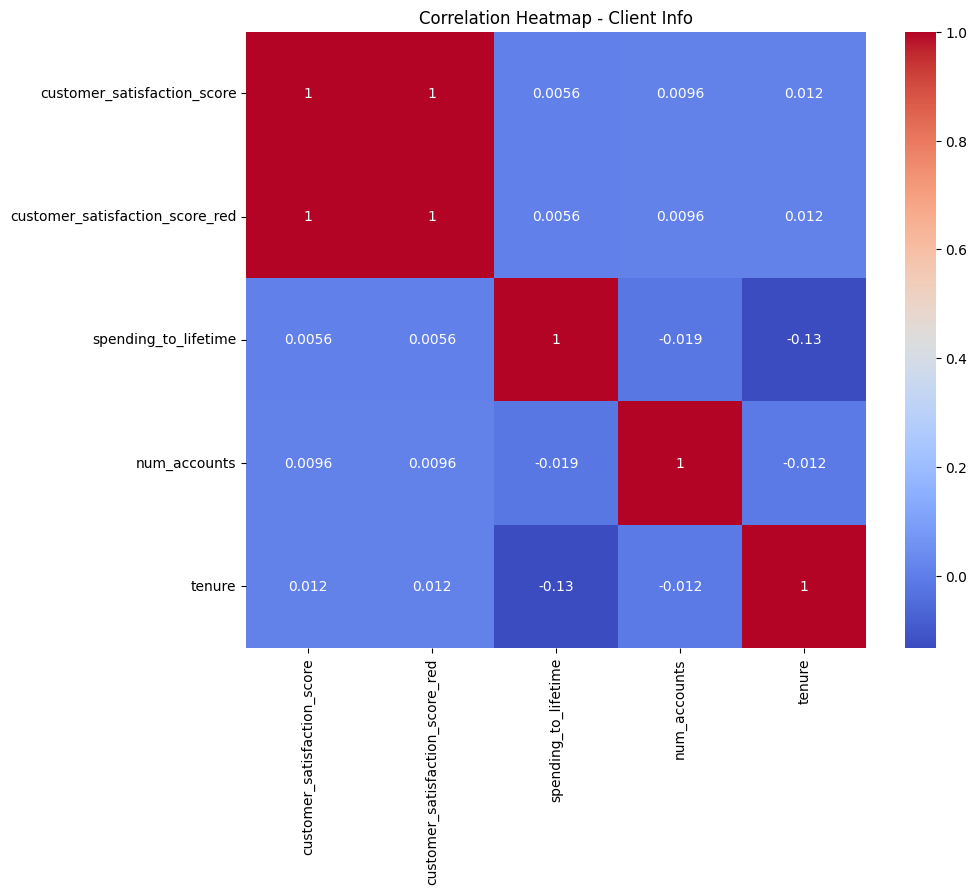

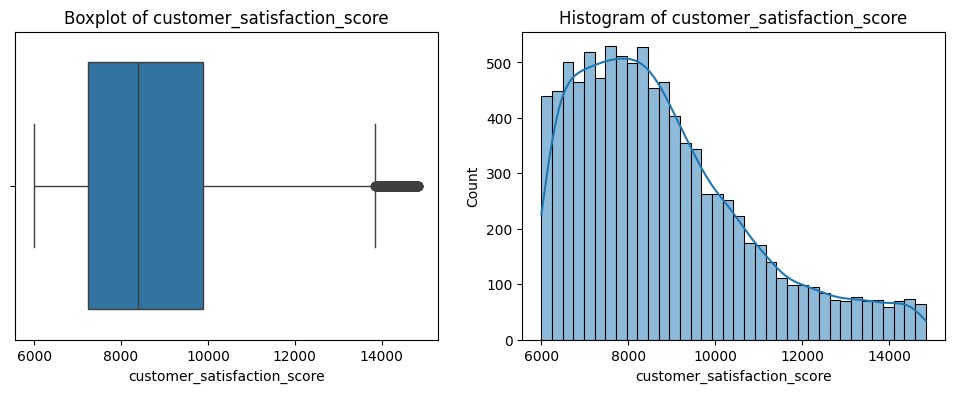

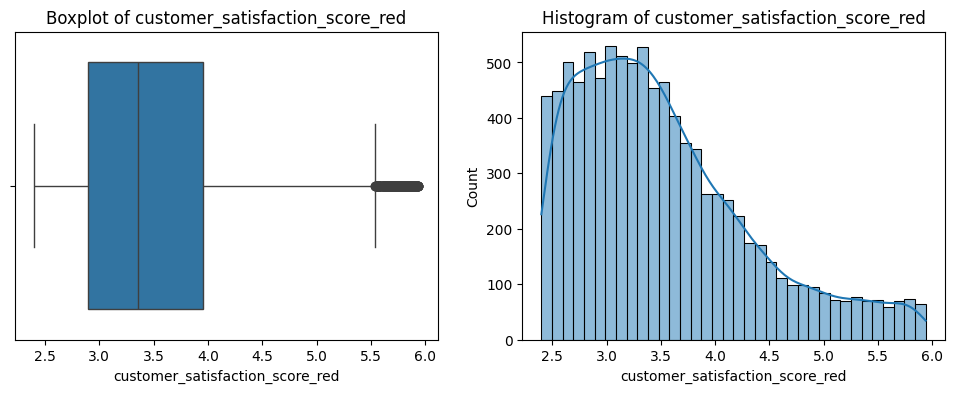

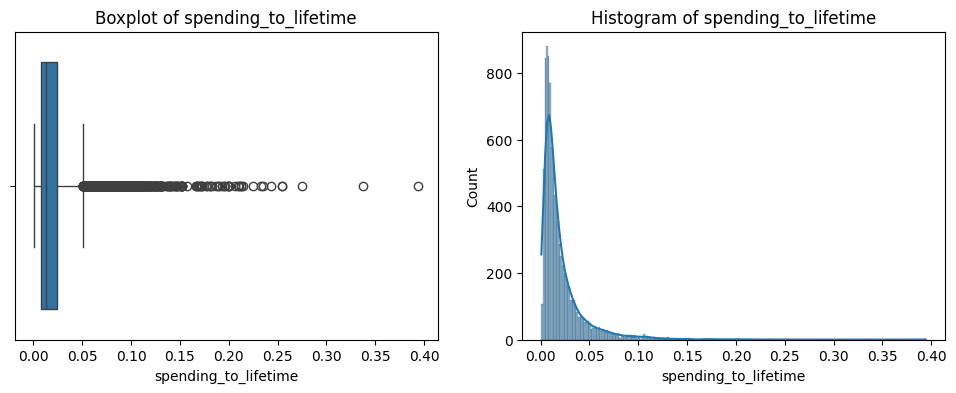

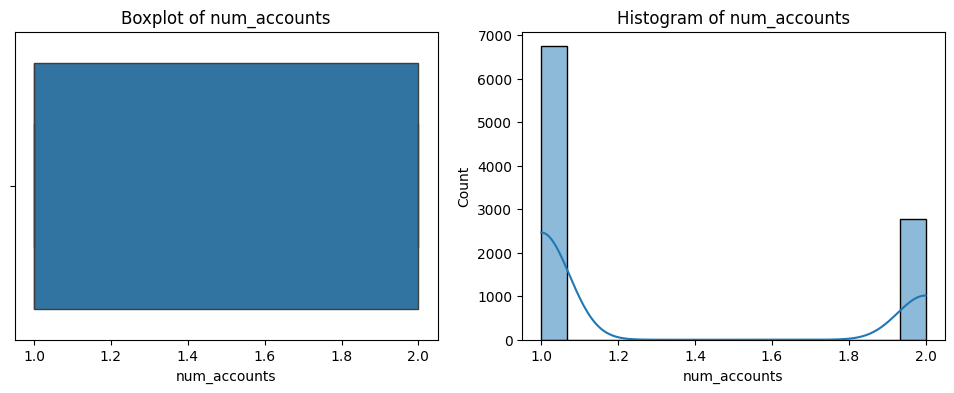

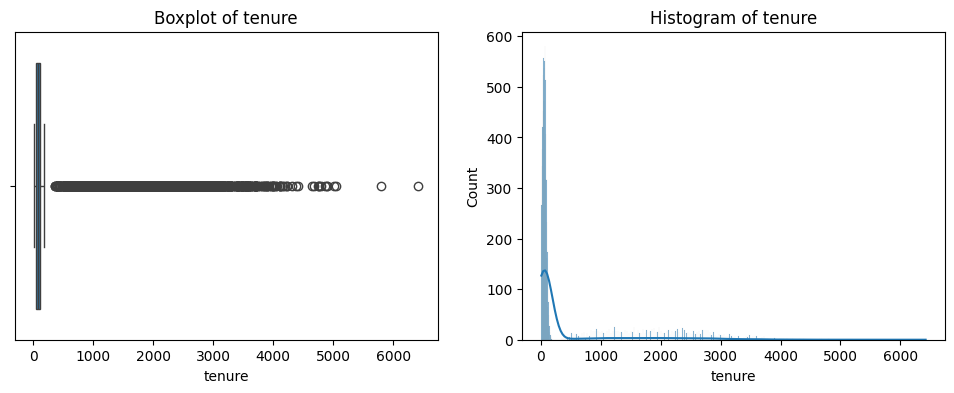

In [9]:
# Correlation heatmap for numeric variables in client_info
plt.figure(figsize=(10, 8))
corr = client_info[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap - Client Info")
plt.show()

# Boxplots and Histograms for key variables
for col in num_cols:
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    sns.boxplot(data=client_info, x=col)
    plt.title(f'Boxplot of {col}')

    plt.subplot(1,2,2)
    sns.histplot(client_info[col].dropna(), kde=True)
    plt.title(f'Histogram of {col}')

    plt.show()

## Data Preparation

In [14]:
# Merge client_info and purchase_info on 'user_id'
df = pd.merge(client_info, purchase_info, on='user_id', how='left')

# Merge city_info: assume client_info.client_location matches city_info.City
df = pd.merge(df, city_info, left_on='client_location', right_on='City', how='left')

# Drop redundant column
df.drop(columns=['City'], inplace=True)

# Handling missing values:
# For simplicity, we fill numeric columns with the median and categorical with mode.
numeric_features = ['customer_satisfaction_score', 'customer_satisfaction_score_red',
                    'spending_to_lifetime', 'num_accounts', 'tenure', 'total_spending', 'average_order_value']
categorical_features = ['client_location', 'activity', 'marital', 'gender', 'churn']

# Convert purchase_info numeric fields to numbers
# THESE ARE DUPLICATED
for col in ['total_spending', 'average_order_value']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute numeric features
num_imputer = SimpleImputer(strategy='median')
df[numeric_features] = num_imputer.fit_transform(df[numeric_features])

# Impute categorical features
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = cat_imputer.fit_transform(df[categorical_features])

# Encode categorical variables using LabelEncoder (or consider OneHotEncoder for more granularity)
le = LabelEncoder()
for col in ['activity', 'marital', 'gender', 'churn', 'client_location']:
    df[col] = le.fit_transform(df[col])

# Feature Scaling for numeric features
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Create training and OOT (Out-Of-Time) samples based on OBS_DATE.
# For example, OOT sample: year 2016-2018, training: others
df['year'] = df['OBS_DATE'].dt.year
oot_mask = df['year'].between(2016, 2018)
df_train = df[~oot_mask].copy()
df_oot = df[oot_mask].copy()

print(f"Training sample size: {df_train.shape[0]}")
print(f"OOT sample size: {df_oot.shape[0]}")

# Define feature set X and target y (assuming 'churn' is our target)
features = numeric_features + ['activity', 'marital', 'gender', 'client_location', 'total_spending', 'average_order_value']
X_train = df_train[features].values  # Convert X_train to a NumPy array
y_train = df_train['churn'].astype(int)

X_test = df_oot[features].values  # Convert X_test to a NumPy array
y_test = df_oot['churn'].astype(int)


Training sample size: 9732
OOT sample size: 3433


## Model Training & Evaluation

In [30]:
# Baseline Model: Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Additional Models

# 1. Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\n---------")
print("\nRandom Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# 2. Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print("\n---------")
print("\nGradient Boosting Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

# 3. XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("\n---------")
print("\nXGBoost Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# 4. LightGBM Classifier
lgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
print("\n---------")
print("\nLightGBM Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))

# 5. MLP Classifier (Neural Network)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
print("\n---------")
print("\nMLP Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))

# 6. Stacking Classifier: Ensemble of the above models
estimators = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False,
                          eval_metric='logloss', random_state=42))
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
print("\n---------")
print("\nStacking Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))

Logistic Regression Evaluation:
Accuracy: 0.8657151179726187
              precision    recall  f1-score   support

           0       0.89      0.97      0.92      2881
           1       0.64      0.40      0.49       475
           2       0.00      0.00      0.00        77

    accuracy                           0.87      3433
   macro avg       0.51      0.45      0.47      3433
weighted avg       0.83      0.87      0.84      3433


---------

Random Forest Evaluation:
Accuracy: 0.8718322167200699
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2881
           1       0.66      0.45      0.53       475
           2       0.00      0.00      0.00        77

    accuracy                           0.87      3433
   macro avg       0.52      0.47      0.49      3433
weighted avg       0.84      0.87      0.85      3433


---------

Gradient Boosting Evaluation:
Accuracy: 0.8762015729682493
              precision    recall  f1-s

## Grid Search for Hyperparameters Improvement

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for each model
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'max_iter': [500, 1000],
    'activation': ['relu', 'tanh']
}

# Function to perform GridSearch and evaluate models
def grid_search_model(model, param_grid, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"\n---------\n{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"\n{model_name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return best_model

# Apply GridSearch to each model
best_lr = grid_search_model(LogisticRegression(max_iter=1000), param_grid_lr, "Logistic Regression")
best_rf = grid_search_model(RandomForestClassifier(random_state=42), param_grid_rf, "Random Forest")
best_gb = grid_search_model(GradientBoostingClassifier(random_state=42), param_grid_gb, "Gradient Boosting")
best_xgb = grid_search_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid_xgb, "XGBoost")
best_lgbm = grid_search_model(lgb.LGBMClassifier(random_state=42), param_grid_lgbm, "LightGBM")
best_mlp = grid_search_model(MLPClassifier(random_state=42), param_grid_mlp, "MLP Classifier")

# Stacking Classifier using best models
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('gb', best_gb),
    ('xgb', best_xgb)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

print("\n---------")
print("\nStacking Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))

Fitting 3 folds for each of 6 candidates, totalling 18 fits

---------
Logistic Regression Best Parameters: {'C': 10, 'solver': 'liblinear'}

Logistic Regression Evaluation:
Accuracy: 0.8657151179726187
              precision    recall  f1-score   support

           0       0.88      0.97      0.93      2881
           1       0.65      0.37      0.47       475
           2       0.00      0.00      0.00        77

    accuracy                           0.87      3433
   macro avg       0.51      0.45      0.47      3433
weighted avg       0.83      0.87      0.84      3433

Fitting 3 folds for each of 12 candidates, totalling 36 fits

---------
Random Forest Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}

Random Forest Evaluation:
Accuracy: 0.8735799592193417
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2881
           1       0.68      0.44      0.54       475
           2       0.00      0.

## Detailed View of Accuracy Metrics

Test Accuracy: 0.90
Test F1 Score: 0.58
Test ROC AUC: 0.91


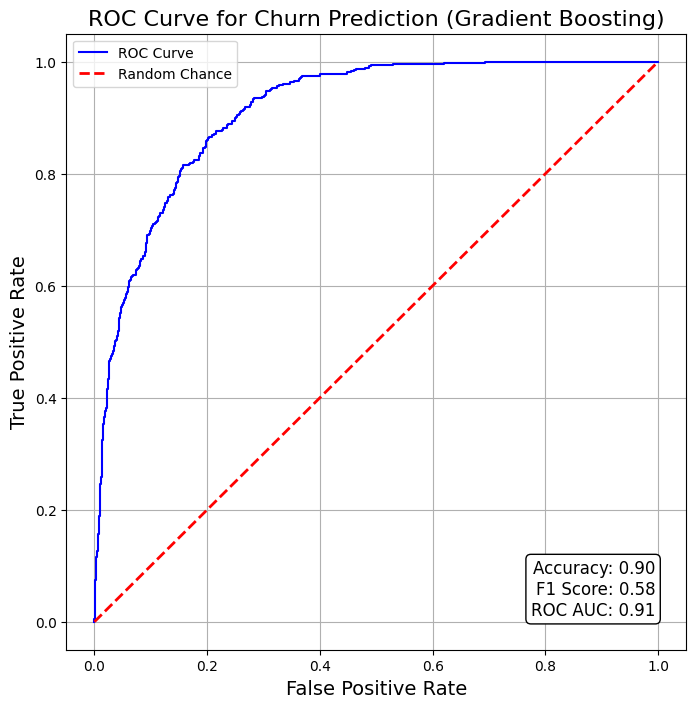

In [25]:
# ---- Using the Best Model: Gradient Boosting Classifier (gb_model) ----
# Convert true labels to binary: assume class 1 represents churn, and others (0 and 2) are non-churn.
y_test_binary = (y_test == 1).astype(int)

# Predictions from the best model
y_pred_gb = gb_model.predict(X_test)
# Convert multi-class predictions to binary: 1 if predicted class is 1, else 0.
y_pred_binary = (y_pred_gb == 1).astype(int)
# Get the probability estimates for churn (class 1)
y_prob = gb_model.predict_proba(X_test)[:, 1]

# Calculate binary classification metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)
roc_auc = roc_auc_score(y_test_binary, y_prob)

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC AUC: {roc_auc:.2f}")

# Compute ROC curve for the binary classification (churn vs. non-churn)
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2, label='Random Chance')
plt.title('ROC Curve for Churn Prediction (Gradient Boosting)', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend()
plt.grid(True)

# Annotate the plot with the evaluation metrics
metrics_text = f"Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nROC AUC: {roc_auc:.2f}"
plt.gca().text(
    0.95,
    0.05,
    metrics_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle="round", facecolor="white", edgecolor="black"),
)

plt.show()

## Model Explainability

In [ ]:
# For tree models, it is recommended to use TreeExplainer. Note that for multiclass
# classification, shap_values is a list (one array per class). Here we explain class 1.
shap.initjs()

# Sample a subset of X_test for explainability
X_test_sample = X_test.sample(500, random_state=21)

# Create the SHAP explainer using the best LightGBM model from grid search
explainer = shap.TreeExplainer(best_lgbm)

# Compute SHAP values. For multiclass, shap_values is a list.
# Here we select the SHAP values for class 1 (adjust if a different class is of interest).
shap_values = explainer.shap_values(X_test_sample)
print("SHAP values shape for class 1:", np.array(shap_values[1]).shape)

# Global Explainability
# Global Force Plot (for a sample explanation)
shap.plots.force(shap.Explanation(values=shap_values[1],
                                  base_values=explainer.expected_value[1],
                                  data=X_test_sample), show=True)

# Global Summary Plot: Visualizes feature impact on the model output
shap.summary_plot(shap_values[1], X_test_sample)

# Global Bar Plot: Ranks features by mean absolute SHAP value
shap.plots.bar(shap.Explanation(values=shap_values[1],
                                base_values=explainer.expected_value[1],
                                data=X_test_sample), max_display=10, show=True)

# Create a heatmap for the top features
feature_names = X_test_sample.columns.tolist()
mean_abs_shap = np.abs(shap_values[1]).mean(axis=0)
sorted_idx = np.argsort(mean_abs_shap)[::-1]
top_features = 15
heatmap_data = pd.DataFrame(shap_values[1][:, sorted_idx[:top_features]],
                            columns=[feature_names[i] for i in sorted_idx[:top_features]])
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="vlag", cbar=True)
plt.title("SHAP Values Heatmap for Top Features")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

# Dependence Plots for the top 4 features
top_features_dependence = [feature_names[i] for i in sorted_idx[:4]]
for feature in top_features_dependence:
    shap.dependence_plot(feature, shap_values[1], X_test_sample, show=True)

In [ ]:
# Local Explainability
instance_idx = 0  # Select an instance from the sample

# Local Force Plot for a single instance
shap.plots.force(shap.Explanation(values=shap_values[1][instance_idx],
                                  base_values=explainer.expected_value[1],
                                  data=X_test_sample.iloc[instance_idx]), show=True)

# Local Waterfall Plot
shap.plots.waterfall(shap.Explanation(values=shap_values[1][instance_idx],
                                      base_values=explainer.expected_value[1],
                                      data=X_test_sample.iloc[instance_idx]), show=True)

# Local Decision Plot
shap.decision_plot(explainer.expected_value[1],
                   shap_values[1][instance_idx],
                   X_test_sample.iloc[instance_idx], show=True)

## Saving the Model

In [ ]:
# Save the best model (and any additional objects like encoders) using pickle.
data_to_save = {"best_model": best_lgbm}  # Extend this dictionary if needed.
model_path = 'models_encoders.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(data_to_save, file)